In [1]:
#Create heatmap of CAZyme secretion, clustered within each set of CAZyme broad specificities.
#(Basically make a bunch of clustered heatmaps, one for each combo of broad specificities)

In [1]:
# Select MAGs to search for CAZymes with HMM of dbCAN database
import pandas as pd
import numpy as np
from Bio import SeqIO
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from Bio import Phylo
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from scipy import stats

In [2]:
#make sure this is bacterial only
representative_hgm_mags = pd.read_csv('~/20210519_signalp_analysis/ipynb_out/representative_hgm_mags.csv')

#Import metadata for HGM MAGs
HGM_species = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_species_info_23790.tsv', sep='\t')
HGM_genomes = pd.read_csv('/home/ec2-user/20190504_HGM_prodigal/IGG_genome_info_206581.tsv', sep='\t')

bac_species = HGM_species[HGM_species['gtdb_taxonomy'].str.contains('d__Bacteria')]['species_id'].tolist()
bac_mags = HGM_genomes[HGM_genomes['species_id'].isin(bac_species)]['genome_id'].unique().tolist()

#Add phylum and family for each OTU
phylist = []
famlist = []

for tax in HGM_species['gtdb_taxonomy']:
    if len(tax.split(';')) > 1:
        phylist.append(tax.split(';')[1].replace('p__',''))
    else:
         phylist.append('NA')
    
    if len(tax.split(';')) > 4:
            famlist.append(tax.split(';')[4].replace('f__',''))
    else:
        famlist.append('NA')
            
HGM_species['Phylum'] = phylist
HGM_species['Family'] = famlist

phycoldict = {'Firmicutes': 'red', 
 'Actinobacteria': 'green', 
 'Bacteroidetes': 'blue', 
 'Proteobacteria': 'orange',
       'Verrucomicrobia': 'lightgreen', 
 'Desulfobacteraeota_A': 'lightblue', 
 'Cyanobacteria': 'gray',
       'Fusobacteria': 'purple', 
 'Spirochaetes': 'yellow', 
 'Elusimicrobia': 'pink',
'Epsilonbacteraeota': 'brown'}

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


```
os.mkdir('/home/ec2-user/20210628_hmm_cazymes_HGM_repmags')
os.mkdir('/home/ec2-user/20210628_hmm_cazymes_HGM_repmags/input_mags')

for mag in representative_hgm_mags['genomeid'].unique().tolist():
    #print(mag)
    magpath = '/home/ec2-user/20200128_HGM_Parks_prodigal/prodigal_output_HGM/faa_output/' + mag + '.faa'
    ! cp $magpath ~/20210628_hmm_cazymes_HGM_repmags/input_mags
```

Run HMMER on representative MAGs against dbCAN
```
$ cd 20210628_hmm_cazymes_HGM_repmags
$ wget http://bcb.unl.edu/dbCAN2/download/dbCAN-HMMdb-V9.txt
$ hmmpress dbCAN-HMMdb-V9.txt &> hmmpress.log
$ wget http://csbl.bmb.uga.edu/dbCAN/download/hmmscan-parser.sh
$ wget http://bcb.unl.edu/dbCAN2/download/Tools/hmmscan-parser.gz
$ gunzip hmmscan-parser.gz
$ chmod +x hmmscan-parser
$ mkdir hmm_dbcan_out
$ cat ~/20210628_hmm_cazymes_HGM_repmags/input_mags/* > ~/20210628_hmm_cazymes_HGM_repmags/input_mags_concat.faa
$ hmmscan --cpu 6 --domtblout hmm_dbcan_out/hmm_cazymes_HGM_repmags.out.dm dbCAN-HMMdb-V9.txt ~/20210628_hmm_cazymes_HGM_repmags/input_mags_concat.faa > hmm_dbcan_out/hmm_cazymes_HGM_repmags.out &> hmm_dbcan_out.log &
$ python hmmscan-parser hmm_dbcan_out/hmm_cazymes_HGM_repmags.out.dm &> 20210628_hmmer_dbcan_parser.log &
```

In [3]:
def count_cazyme_cats(eggnog_output_sel):
    #Number of secreted proteins that fit in each cazyme category
    cazyme_counts_dict = dict()
    for cazymecat in eggnog_output_sel['CAZy'].fillna('None'):
        list_of_cats = cazymecat.split(',')
        for cat in list_of_cats:
            if cat in cazyme_counts_dict.keys():
                cazyme_counts_dict[cat] = cazyme_counts_dict[cat] + 1
            else:
                cazyme_counts_dict[cat] = 1

    return(cazyme_counts_dict)

```
hmmscan_parser_names = ['target_name','target_len','query_name','query_len','e-value',
                        'target_start','target_end','query_start','query_end','coverage']
hmmer_dbcan_parser = pd.read_csv('~/20210628_hmm_cazymes_HGM_repmags/20210628_hmmer_dbcan_parser.log', sep='\t', header=None,
           names=hmmscan_parser_names)

hmmer_dbcan_parser['genome_id'] = ['_'.join(orf.split('_')[:2]) for orf in hmmer_dbcan_parser['query_name']]

hmmer_dbcan_parser['cazyme_fam'] = [item.replace('.hmm','') for item in hmmer_dbcan_parser['target_name']]

#Add secretion prediction

HGM_master_sec_nonsec = pd.read_csv('~/20210602_metasecretome_figures/ipynb_out/HGM_master_sec_nonsec.tsv', sep='\t',
                                   usecols=['orfid','Secreted'])
HGM_master_sec_nonsec['genomeid'] = ['_'.join(orfid.split('_')[:2]) for orfid in HGM_master_sec_nonsec['orfid']]

sec_orfs = HGM_master_sec_nonsec[HGM_master_sec_nonsec['Secreted'] == 'Secreted']['orfid'].tolist()
```

In [4]:
percsec_famcazy_mag_df = pd.read_csv('ipynb_out/percsec_famcazy_mag_df_v8.tsv', sep='\t', index_col=0)

In [5]:
total_famcazy_mag_df = pd.read_csv('ipynb_out/total_famcazy_mag_df_v8.tsv', sep='\t', index_col=0)

In [6]:
fam_presence_mags = np.sum(total_famcazy_mag_df >= 1, axis=1)
fams_in_over2mags = fam_presence_mags[fam_presence_mags > 1].index.tolist()

In [7]:
len(fams_in_over2mags)

144

In [8]:
total_famcazy_mag_df.shape

(151, 765)

/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


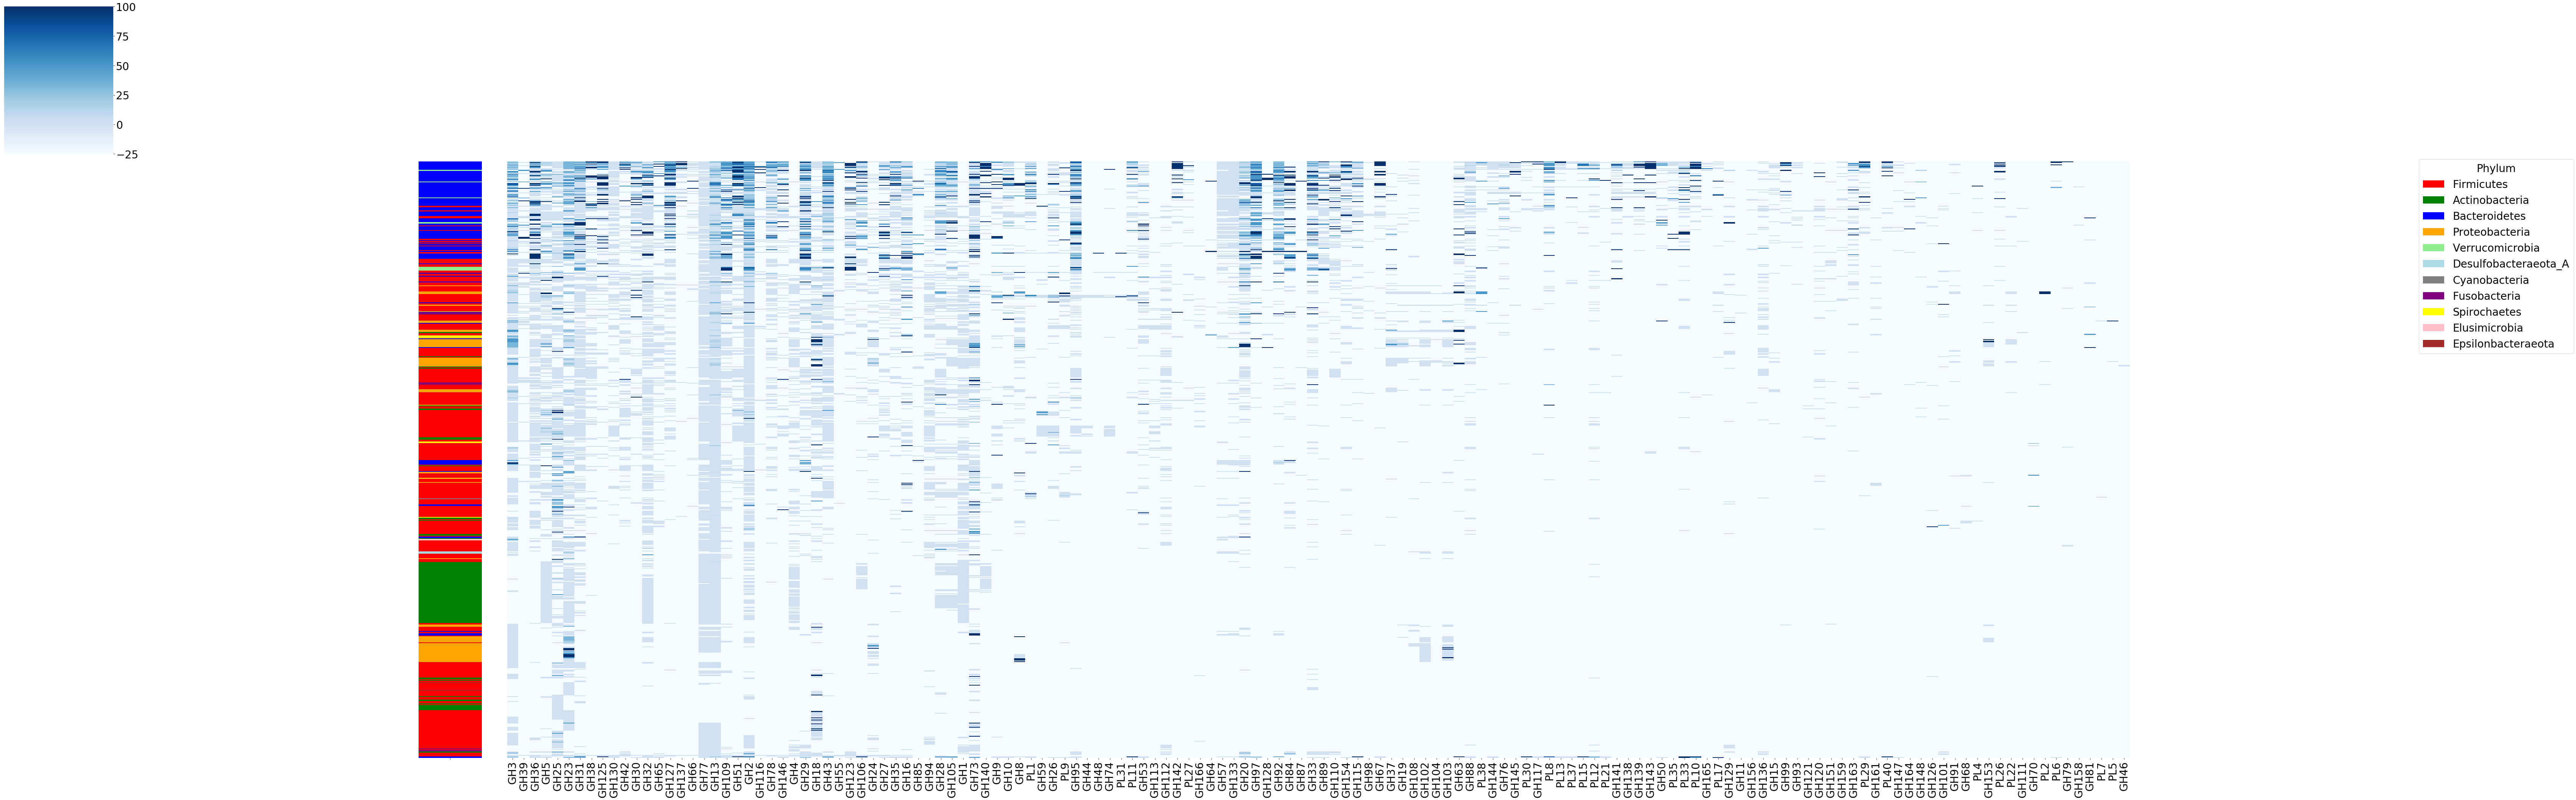

In [10]:
#Make a clustermap where we color each MAG by family
genomeid_fam = HGM_genomes[HGM_genomes.repository == 'HGM'].join(HGM_species.set_index('species_id'), 'species_id')[['genome_id','Family']]
genomeid_phy = HGM_genomes[HGM_genomes.repository == 'HGM'].join(HGM_species.set_index('species_id'), 'species_id')[['genome_id','Phylum']]

phylist = percsec_famcazy_mag_df.transpose().join(genomeid_phy.set_index('genome_id'))['Phylum'].tolist()
col_colors = pd.Series(phylist).map(phycoldict)

#Filter CAZyme families that only appear in 1 MAG

plt.rcParams.update({'font.size': 28})

#Order MAGs using phylogenetic tree

#Order CAZyme families by broad substrate
#percsec_famcazy_mag_df.loc[fams_in_over2mags, mag_order]
selcazyfams = percsec_famcazy_mag_df.loc[fams_in_over2mags].fillna(-0.25*100).transpose()
cg = sns.clustermap(selcazyfams.reset_index(drop=True), 
                    #cmap=sns.color_palette("Blues", as_cmap=True),
                    cmap="Blues",
                    row_colors=col_colors,
                    row_cluster=True, col_cluster=False,
                    method='single',
                    metric='hamming',
                    figsize=(80,30),
                    #cbar_pos=(1.0, 0.6, 0.03, 0.2),
                    #dendrogram_ratio=0.2,
                    #linewidths=1, linecolor='0.9',
                    yticklabels=False,
                    xticklabels=1)
#plt.title('% secreted CAZymes per MAG')
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)
#clustergrid.dendrogram_row.reordered_ind
cg.ax_heatmap.yaxis.get_majorticklabels()
handles = [mpatches.Patch(facecolor=phycoldict[name]) for name in phycoldict]
plt.legend(handles, phycoldict, title='Phylum',
          bbox_to_anchor=(1.2, 0.8), bbox_transform=plt.gcf().transFigure)#, loc='upper right')
# plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_mag_phycol.eps',format='eps', bbox_inches="tight")
# plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_mag_phycol.png',format='png', bbox_inches="tight")

#Get order of clustered GH and PLs
reordered_row_inds = cg.dendrogram_row.reordered_ind
original_row_list = percsec_famcazy_mag_df.transpose().index.tolist()
reordered_row_list = []
reordered_col_colors = []
for row in reordered_row_inds:
    reordered_row_list.append(original_row_list[row])
    reordered_col_colors.append(col_colors[row])
plt.show()

In [11]:
relevant_ghpls = fams_in_over2mags

broad_substrate_dict = {'Plant Cell Wall Carbohydrates': ['GH1', 'GH2', 'GH3', 'GH4', 'GH5', 'GH8', 'GH9', 'GH11', 'GH12', 'GH15', 'GH16', 'GH17', 'GH26', 'GH27', 'GH28', 'GH29', 'GH36', 'GH39', 'GH43', 'GH44', 'GH48', 'GH51', 'GH53', 'GH55', 'GH67', 'GH74', 'GH78', 'GH93', 'GH94', 'GH95', 'GH115', 'GH117', 'GH121', 'PL1', 'PL2', 'PL6', 'PL7', 'PL9', 'PL11', 'PL15', 'PL22'],
'Animal Carbohydrates': ['GH1', 'GH2', 'GH3', 'GH4', 'GH18', 'GH19', 'GH20', 'GH29', 'GH33', 'GH38', 'GH58', 'GH79', 'GH84', 'GH85', 'GH88', 'GH89', 'GH92', 'GH95', 'GH98', 'GH99', 'GH101', 'GH105', 'GH109', 'GH110', 'GH113', 'PL6', 'PL8', 'PL12', 'PL13', 'PL21'],
'Peptidoglycan': ['GH23' 'GH24', 'GH25', 'GH73', 'GH102', 'GH103', 'GH104', 'GH108'],
'Starch or Glycogen': ['GH13', 'GH15', 'GH57', 'GH77'],
'Sucrose or Fructans': ['GH32', 'GH68', 'GH70', 'GH91'],
'Fungal Carbohydrates': ['GH5', 'GH8', 'GH16', 'GH18', 'GH19', 'GH20', 'GH55', 'GH64', 'GH71', 'GH81'],
'Dextran': ['GH66', 'GH70', 'GH87']}

ghpl_broad_substrate_df = pd.DataFrame()
#relevant_ghpls = percsec_famcazy_mag_df.index.tolist()
all_ghpl_broad_substrate_dict = dict()

for ghpl in relevant_ghpls:
    ghpl_broad_substrate_dict = dict()
    substrateslist = []
    for substrate in broad_substrate_dict.keys():
        if ghpl in broad_substrate_dict[substrate]:
            ghpl_broad_substrate_dict[substrate] = 1
            substrateslist.append(substrate)
        else:
            ghpl_broad_substrate_dict[substrate] = 0
    ghpl_broad_substrate_df = ghpl_broad_substrate_df.append(pd.Series(ghpl_broad_substrate_dict, name=ghpl))
    all_ghpl_broad_substrate_dict[ghpl] = ','.join(substrateslist)


In [12]:
#Added some broad substrates manually doing a combo of literature 
#search and activities comparison
#Edited cazyfam_activities_broad_substrates.tsv
cazyact_manedit_df = pd.read_csv('cazyact_table_manedit.txt', sep='\t').fillna('')

expanded_ghpl_broad_substrate_df = pd.DataFrame()

for ghpl in relevant_ghpls:
    ghpl_broad_substrate_dict = dict()
    substrateslist = []
    for substrate in broad_substrate_dict.keys():
        if substrate in cazyact_manedit_df[cazyact_manedit_df['cazy'] == ghpl]['broad_substrates'].tolist()[0]:
            ghpl_broad_substrate_dict[substrate] = 1
            substrateslist.append(substrate)
        else:
            ghpl_broad_substrate_dict[substrate] = 0
    expanded_ghpl_broad_substrate_df = expanded_ghpl_broad_substrate_df.append(pd.Series(ghpl_broad_substrate_dict, name=ghpl))

In [13]:
#df["period"] = 
expanded_ghpl_broad_substrate_df["bsbarcode"] = expanded_ghpl_broad_substrate_df["Animal Carbohydrates"].astype(str) + expanded_ghpl_broad_substrate_df["Dextran"].astype(str) + expanded_ghpl_broad_substrate_df["Fungal Carbohydrates"].astype(str) + expanded_ghpl_broad_substrate_df["Peptidoglycan"].astype(str) + expanded_ghpl_broad_substrate_df["Plant Cell Wall Carbohydrates"].astype(str) + expanded_ghpl_broad_substrate_df["Starch or Glycogen"].astype(str) + expanded_ghpl_broad_substrate_df["Sucrose or Fructans"].astype(str)
#expanded_ghpl_broad_substrate_df

In [14]:
groupedbs = expanded_ghpl_broad_substrate_df.groupby("bsbarcode")

0.00.00.00.00.00.00.0


/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


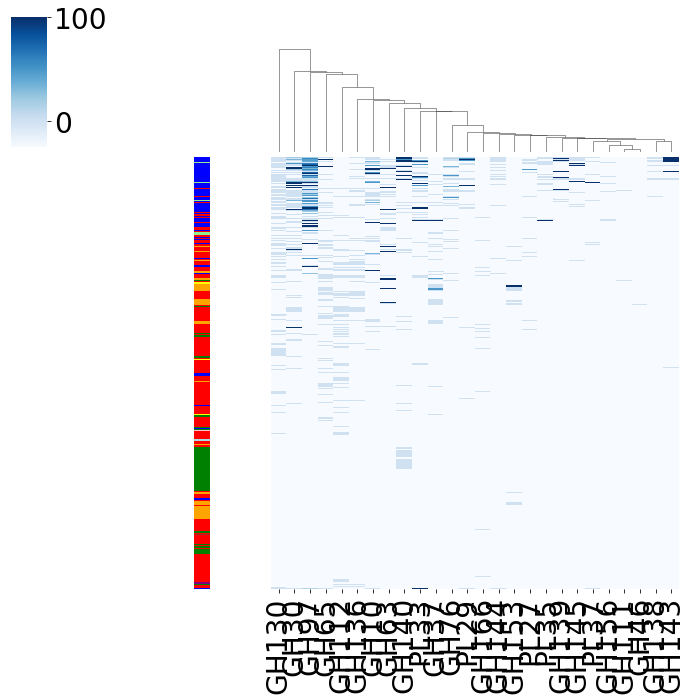

0.00.00.00.00.00.01.0


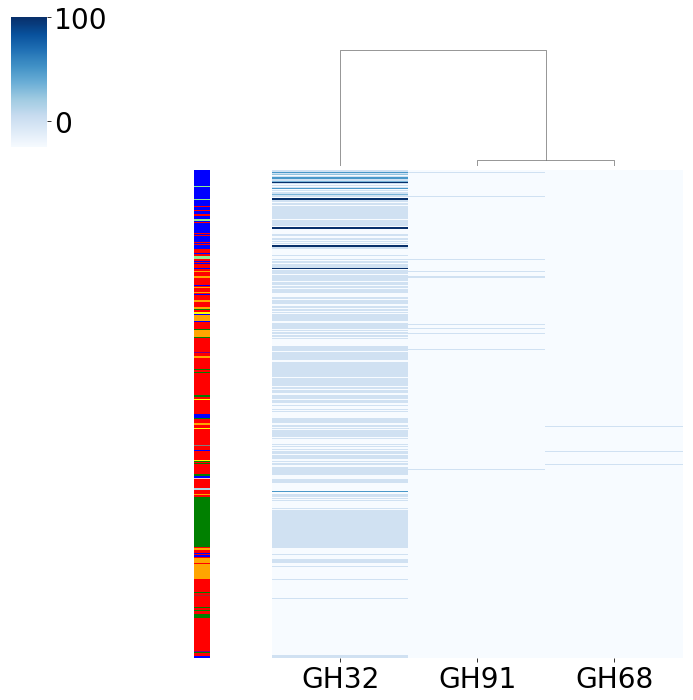

0.00.00.00.00.01.00.0


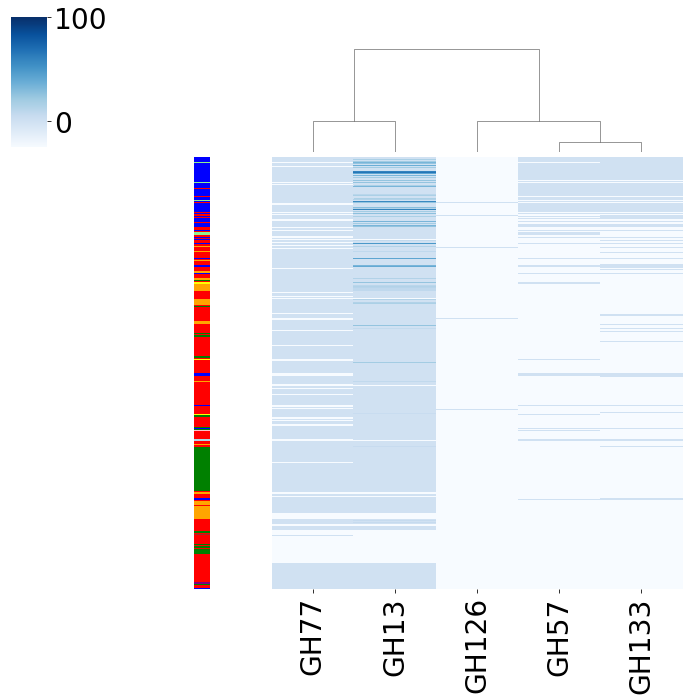

0.00.00.00.01.00.00.0


/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


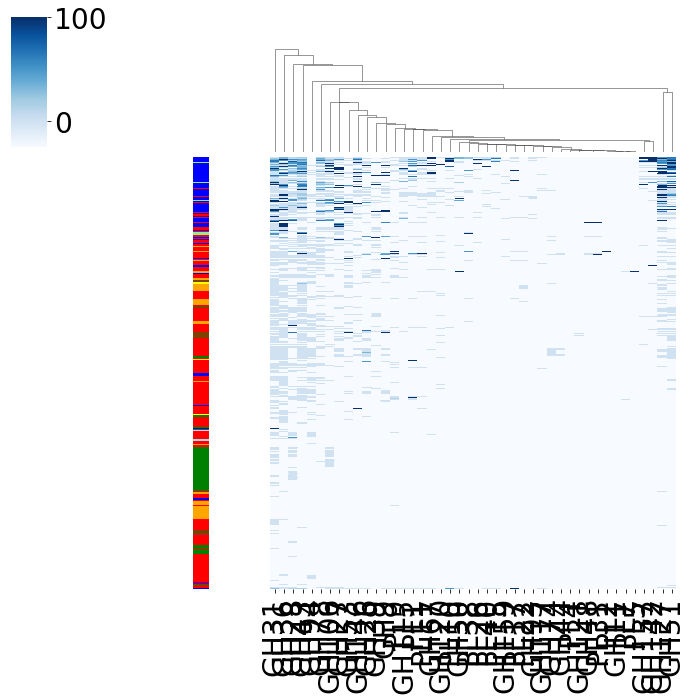

0.00.00.00.01.01.00.0


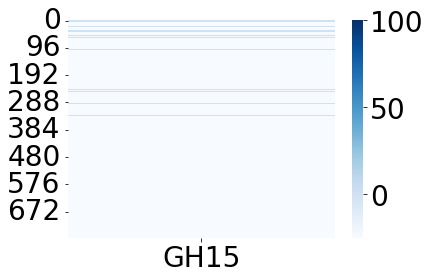

0.00.00.01.00.00.00.0


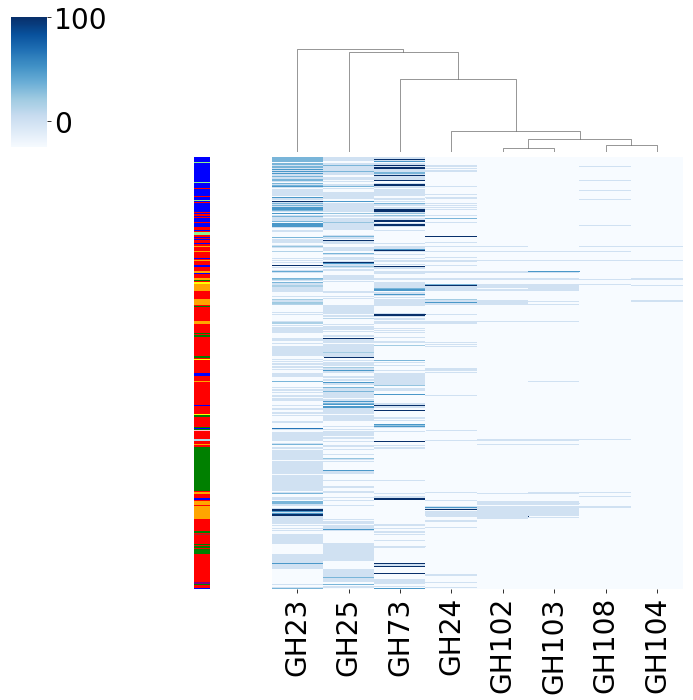

0.00.01.00.00.00.00.0


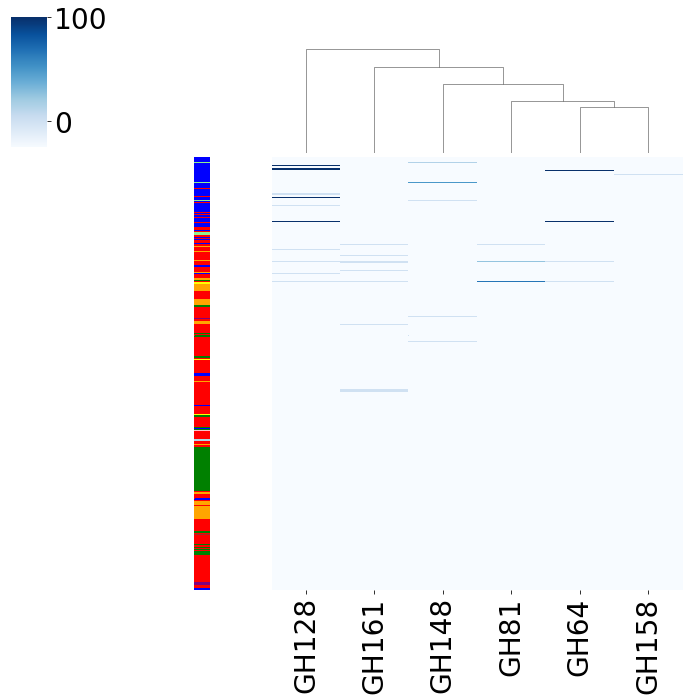

0.00.01.00.01.00.00.0


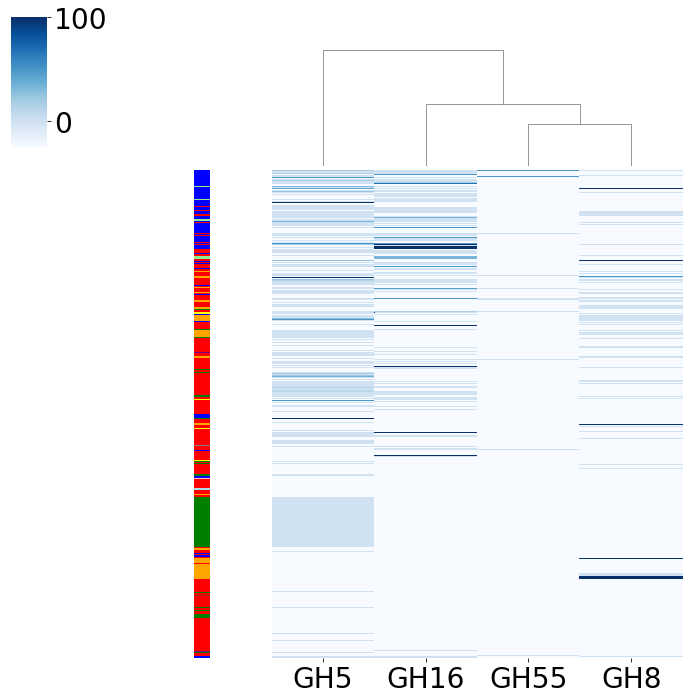

0.01.00.00.00.00.00.0


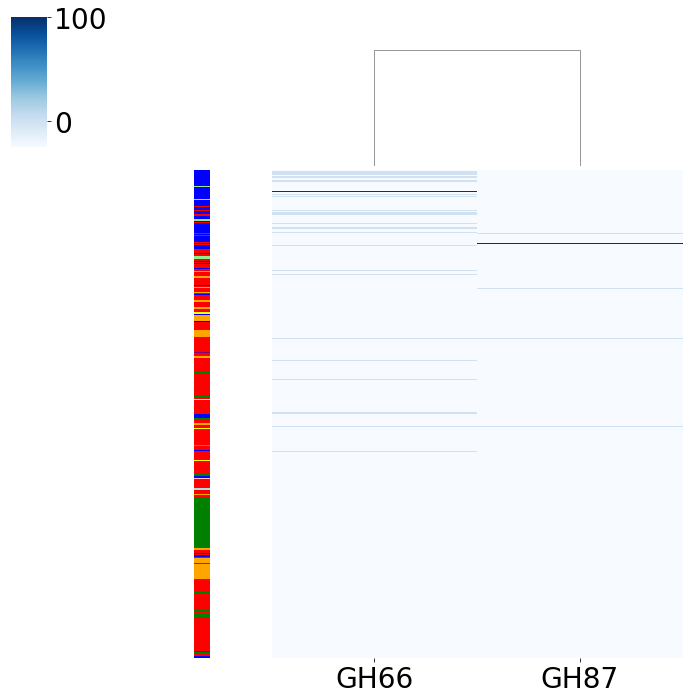

0.01.00.00.00.00.01.0


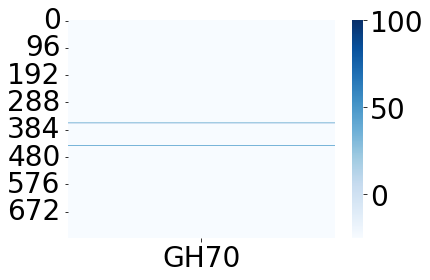

1.00.00.00.00.00.00.0


/home/ec2-user/bin/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


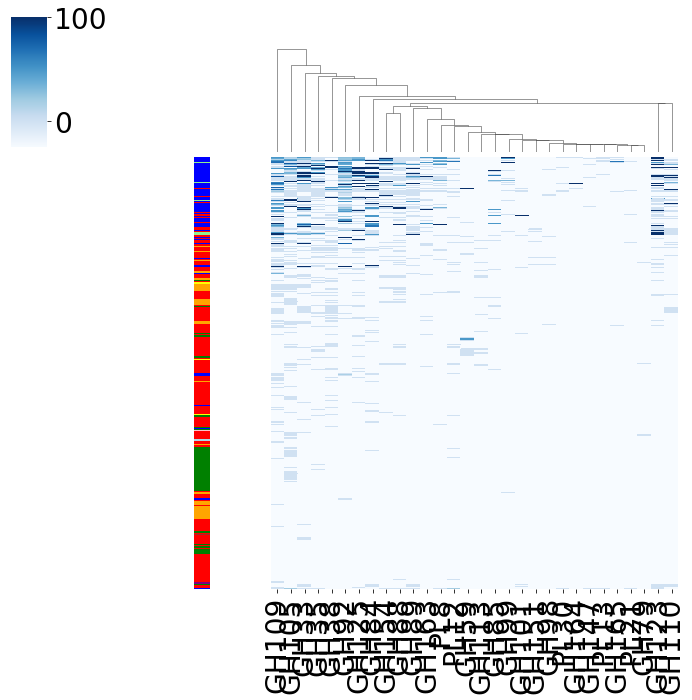

1.00.00.00.01.00.00.0


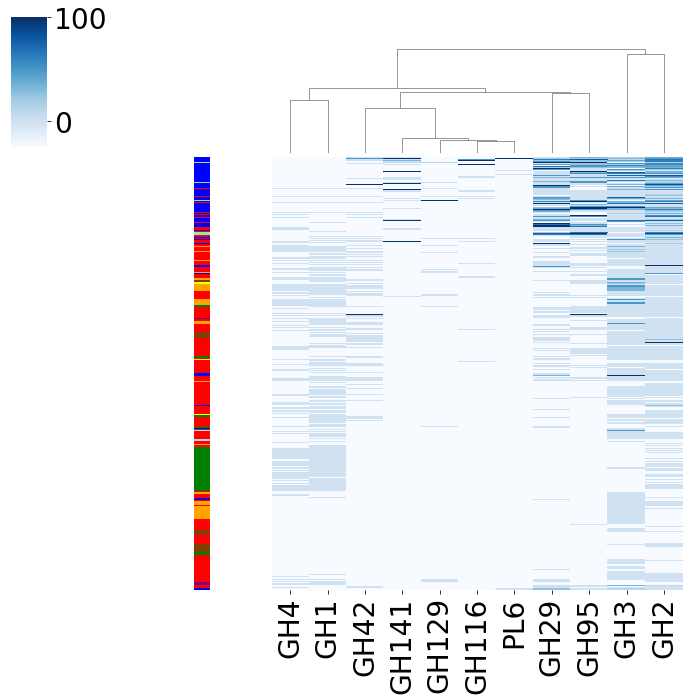

1.00.01.00.00.00.00.0


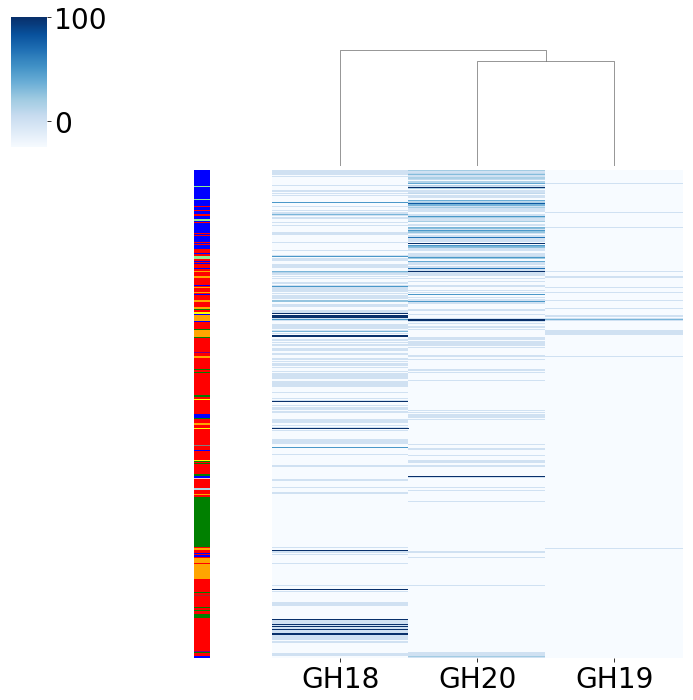

In [15]:
plt.rcParams['svg.fonttype'] = 'none'

all_reordered_cazymefams = []
for name, group in groupedbs:
    print(name)
    cazymefams = group.index.tolist()
    if len(cazymefams) > 1:
        #Plot heatmap for cazyme families belonging to each broad substrate group
        #Order MAGs using phylogenetic tree
        #Order CAZyme families by broad substrate and cluster within each broad substrate
        cg = sns.clustermap(selcazyfams.loc[reordered_row_list,cazymefams].reset_index(drop=True), 
                #cmap=sns.color_palette("Blues", as_cmap=True),
                cmap="Blues",
                row_colors=reordered_col_colors,
                row_cluster=False, col_cluster=True,
                method='single',
                metric='hamming',
                vmin=-0.25*100, vmax=100,
                #figsize=(80,30),
                #cbar_pos=(1.0, 0.6, 0.03, 0.2),
                #dendrogram_ratio=0.2,
                #linewidths=1, linecolor='0.9',
                yticklabels=False,
                xticklabels=1)
        #plt.title('% secreted CAZymes per MAG')
        cg.ax_row_dendrogram.set_visible(False)
        cg.ax_col_dendrogram.set_visible(True)
        #clustergrid.dendrogram_row.reordered_ind
        cg.ax_heatmap.yaxis.get_majorticklabels()
        handles = [mpatches.Patch(facecolor=phycoldict[name]) for name in phycoldict]
        
        reordered_cazymefams = []
        for col in cg.dendrogram_col.reordered_ind:
            reordered_cazymefams.append(cazymefams[col])
        all_reordered_cazymefams = all_reordered_cazymefams + reordered_cazymefams
        #plt.legend(handles, phycoldict, title='Phylum',
        #          bbox_to_anchor=(1.2, 0.8), bbox_transform=plt.gcf().transFigure)#, loc='upper right')
        plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_mag_phycol_' + name.replace('.','_') + '.svg',format='svg', bbox_inches="tight")
        plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_mag_phycol_' + name.replace('.','_') + '.png',format='png')
    else:
        all_reordered_cazymefams = all_reordered_cazymefams + cazymefams
        cg = sns.heatmap(selcazyfams.loc[reordered_row_list,cazymefams].reset_index(drop=True), 
                #cmap=sns.color_palette("Blues", as_cmap=True),
                vmin=-0.25*100, vmax=100,
                cmap="Blues")
                #row_colors=col_colors)
                #row_cluster=False, col_cluster=True,
                #method='single',
                #metric='hamming',
                #figsize=(80,30))
                #cbar_pos=(1.0, 0.6, 0.03, 0.2),
                #dendrogram_ratio=0.2,
                #linewidths=1, linecolor='0.9',
                #yticklabels=False)
        #cg.ax_row_dendrogram.set_visible(False)
        #cg.ax_col_dendrogram.set_visible(True)
        #clustergrid.dendrogram_row.reordered_ind
        #cg.ax_heatmap.yaxis.get_majorticklabels()
        handles = [mpatches.Patch(facecolor=phycoldict[name]) for name in phycoldict]
        #plt.legend(handles, phycoldict, title='Phylum',
        #          bbox_to_anchor=(1.2, 0.8), bbox_transform=plt.gcf().transFigure)#, loc='upper right')
        plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_mag_phycol_' + name.replace('.','_') + '.svg',format='svg')
        plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_mag_phycol_' + name.replace('.','_') + '.png',format='png')
    plt.show()
    

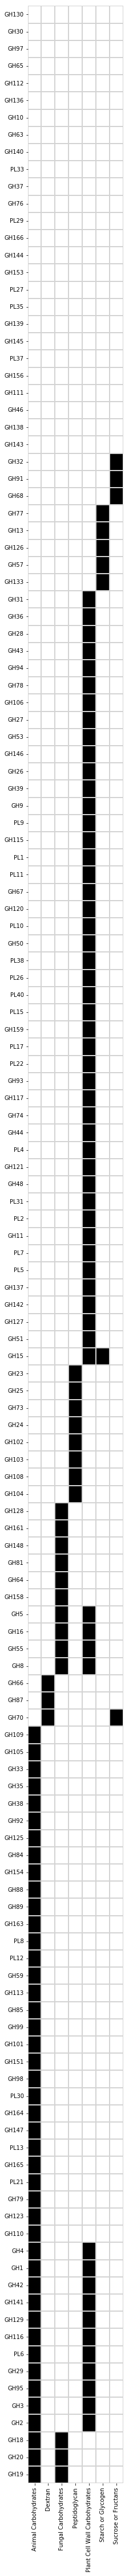

In [16]:
#Generate table of broad substrates, in order of clustered CAZyme families above

plt.rcParams.update({'font.size': 10})
plt.rcParams['svg.fonttype'] = 'none'

plt.figure(figsize=(3,80))

sorted_ghpls_df = expanded_ghpl_broad_substrate_df.sort_values(expanded_ghpl_broad_substrate_df.columns.tolist(),
                                                              axis=0, ascending=False, inplace=False)

sorted_ghpls_list = sorted_ghpls_df.index.tolist()
sorted_ghpls_list = ['GH18',
 'GH20',
 'GH19',
 'GH3',
 'GH42',
 'GH2',
 'GH116',
 'GH4',
 'GH29',
 'GH1',
 'GH95',
 'GH141',
 'GH129',
 'PL6',
 'GH38',
 'GH125',
 'GH109',
 'GH123',
 'GH35',
 'GH85',
 'GH105',
 'GH59',
 'GH113',
 'GH92',
 'GH84',
 'GH33',
 'GH89',
 'GH110',
 'GH154',
 'GH98',
 'GH88',
 'PL30',
 'PL8',
 'PL13',
 'PL12',
 'PL21',
 'GH165',
 'GH99',
 'GH151',
 'GH163',
 'GH147',
 'GH164',
 'GH101',
 'GH79',
 'GH70',
 'GH66',
 'GH87',
 'GH5',
 'GH55',
 'GH16',
 'GH8',
 'GH64',
 'GH128',
 'GH161',
 'GH148',
 'GH158',
 'GH81',
 'GH25',
 'GH23',
 'GH24',
 'GH73',
 'GH108',
 'GH102',
 'GH104',
 'GH103',
 'GH15',
 'GH39',
 'GH36',
 'GH31',
 'GH127',
 'GH137',
 'GH51',
 'GH78',
 'GH146',
 'GH43',
 'GH106',
 'GH27',
 'GH94',
 'GH28',
 'GH9',
 'PL1',
 'GH26',
 'PL9',
 'GH44',
 'GH48',
 'GH74',
 'PL31',
 'PL11',
 'GH53',
 'GH142',
 'GH115',
 'GH67',
 'PL38',
 'GH117',
 'PL15',
 'GH50',
 'PL10',
 'PL17',
 'GH11',
 'GH93',
 'GH121',
 'GH120',
 'GH159',
 'PL40',
 'PL4',
 'PL26',
 'PL22',
 'PL2',
 'PL7',
 'PL5',
 'GH77',
 'GH13',
 'GH57',
 'GH133',
 'GH126',
 'GH32',
 'GH91',
 'GH68']
plt.rcParams['svg.fonttype'] = 'none'
ax = sns.heatmap(sorted_ghpls_df.loc[all_reordered_cazymefams].drop(labels='bsbarcode', axis=1, inplace=False), #sorted_ghpls_df.loc[sorted_ghpls_list], 
                 linewidths=1, linecolor='lightgray',
                   yticklabels=True,cbar=False, 
                 cmap=sns.color_palette("cubehelix_r", as_cmap=True))
plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_specificity.png', bbox_inches='tight', transparent=True)
plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_specificity.svg', bbox_inches='tight', transparent=True)
plt.savefig('ipynb_out/Figures_eps/Fig3_v15_percsec_famcazy_specificity.eps', bbox_inches='tight', transparent=True)
plt.show()
#Change colors later... dark should probably imply presence rather than absence